In [1]:
import cryoenv.cryosig as cs
import numpy as np
import time
from scipy.constants import e
from tqdm.auto import trange
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [2]:
# standard scenario
det = cs.DetectorModule(# which_curve='Rt_kinky',
                        # Tb=cs.RandomWalkBath(b=1e-3),
                       )

# heater on tes scenario
# det = cs.DetectorModule(
#     delta=np.array([[0.99, 0.01]]),
#     dac=np.array([0.]),
#     pulser_scale=np.array([.1]),
#     heater_attenuator=np.array([1.]),
#     heater_flag=np.array([True,  False]),
#     dac_ramping_speed=np.array([0.002]),
#     tau=np.array([10]),
#                        )

# two heaters scenario
# det = cs.DetectorModule(
#     Rh=np.array([10, 10]),
#     delta=np.array([[0.99, 0.01], [0.01, 0.99]]),
#     dac=np.array([0., 0.]),
#     pulser_scale=np.array([1., 1.]),
#     heater_attenuator=np.array([1., 1.]),
#     heater_flag=np.array([True,  True]),
#     dac_ramping_speed=np.array([0.002, 0.002]),
#     tau=np.array([10]),
#                        )

# two tes with heater on tes scenario
# det = cs.DetectorModule(
#     C=np.array([5e-5, 5e-5, 5e-4]),  # first two components are TES
#     Gb=np.array([0.005, 0.005, 0.005]),
#     G=np.array([[0.   , 0.   , 0.001],
#                 [0.   , 0.   , 0.001],
#                 [0.001, 0.001, 0.   ],]),
#     lamb=0.003,
#     eps=np.array([[0.99, 0.  , 0.01],
#                [0.  , 0.99, 0.01], 
#                [0.05 ,0.05, 0.90],]),
#     delta=np.array([[0.98, 0., 0.02], [0., 0.98, 0.02], ]),
#     Rs=np.array([0.035, 0.035]),
#     Rh=np.array([10, 10]),
#     L=np.array([3.5e-07, 3.5e-07]),
#     Rt0=np.array([0.2, 0.2]),
#     k=np.array([2., 2.]),
#     Tc=np.array([15., 15.]),
#     Ib=np.array([1., 1.]),
#     dac=np.array([0., 0.]),
#     pulser_scale=np.array([1., 1.]),
#     heater_attenuator=np.array([1., 1.]),
#     tes_flag=np.array([ True, True, False]),
#     heater_flag=np.array([True,  True, False]),
#     pileup_prob=0.05,
#     pileup_comp=2,
#     dac_ramping_speed=np.array([0.002, 0.002]),
#     Ib_ramping_speed=np.array([0.005, 0.005]),
#     xi=np.array([1., 1.]),
#     i_sq=np.array([2.e-12, 2.e-12]),
#     tes_fluct=np.array([0.0005, 0.0005]),
#     emi=np.array([2.e-10, 2.e-10]),
#     tau=np.array([10]),
#                        )


In [17]:
det.set_control(dac=[1.05], Ib=[1], norm=False)
# det.set_control(dac=[.10], Ib=[2], norm=False)
# det.set_control(dac=[.2, .2], Ib=[1, 1], norm=False)
# det.set_control(dac=[-0.92, -1], Ib=[-0.8, -1], norm=True)

In [18]:
det.wait(5)

In [19]:
for i in range(5):
    det.wait(5)
    print(det.dac, det.U_sq_Rh)

[1.05] [4.20569036]
[1.05] [2.96402296]
[1.05] [2.21091361]
[1.05] [1.7541297]
[1.05] [1.47707625]


In [20]:
det.trigger(er=np.array([0., 0.]), tpa=np.array([10.]), verb=True)
# det.trigger(er=np.array([0., 0., 0.]), tpa=np.array([.01, .0]), verb=True)

T0 is [16.40878012 36.02704192] mK.
Calculated in 0.10924696922302246 s.
Generated noise in 0.004583120346069336 s.


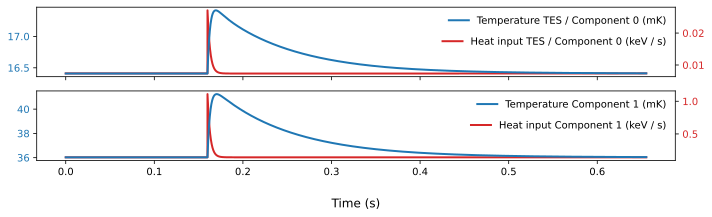

In [21]:
det.plot_temperatures(save_path='plots_paper/temperatures.png')

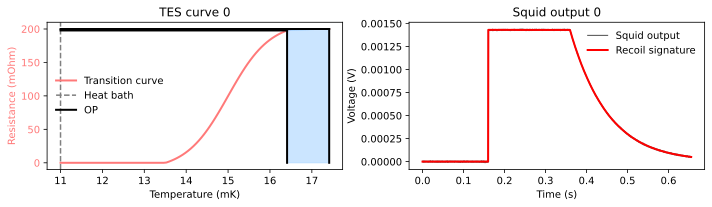

In [22]:
det.plot_tes(save_path='plots_paper/tes.png')

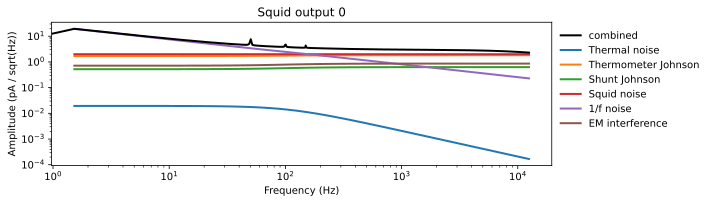

In [23]:
for i in range(det.nmbr_tes):
    det.plot_nps(tes_channel=i, only_sum=False, save_path='plots_paper/nps_tes_{}.png'.format(i))


In [34]:
det.send_testpulses(nmbr_tp=30)

  0%|          | 0/30 [00:00<?, ?it/s]

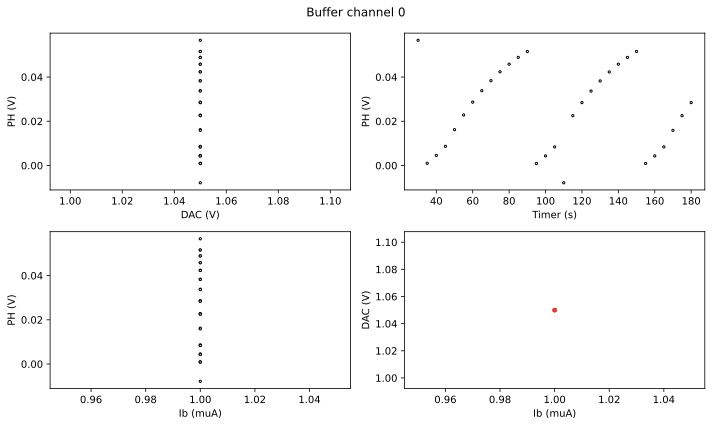

In [35]:
det.plot_buffer()